In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score
)

feature_names = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 
                 'Group', 'Collage', 'Human', 'Info', 'Blur']

df = pd.read_csv('Data/train.csv')
X = df[feature_names]
y = df['Occlusion']

print(X.head())

print(f'Number of features in X_train: {X.shape[1]}')

   Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      1        0      0   
1              0     1     1     0       0          0      0        0      0   
2              0     1     1     1       0          0      0        0      1   
3              0     1     1     1       0          0      0        0      0   
4              0     0     0     1       0          0      1        0      0   

   Info  Blur  
0     0     0  
1     0     0  
2     0     0  
3     0     0  
4     0     0  
Number of features in X_train: 11


In [133]:
# Fit mutual information
mi = mutual_info_classif(X, y)

# Sort and display the most important features
feature_importance = np.argsort(mi)[::-1]  # Sort descending

for i in feature_importance:
    print(f"Feature {feature_names[i]}: Importance {mi[i]:.4f}")

Feature Human: Importance 0.1600
Feature Subject Focus: Importance 0.0124
Feature Info: Importance 0.0096
Feature Eyes: Importance 0.0049
Feature Face: Importance 0.0009
Feature Collage: Importance 0.0005
Feature Blur: Importance 0.0000
Feature Action: Importance 0.0000
Feature Accessory: Importance 0.0000
Feature Group: Importance 0.0000
Feature Near: Importance 0.0000


In [134]:
from sklearn.feature_selection import SelectKBest, chi2

# Select top 5 features based on Chi-squared test
selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(X, y)

# Get indices of the top features selected
top_features_indices = selector.get_support(indices=True)

# Print the top features with their names
print("Top 5 selected features:")
for i in top_features_indices:
    print(f"Feature {feature_names[i]}")

Top 5 selected features:
Feature Subject Focus
Feature Accessory
Feature Collage
Feature Human
Feature Info


In [135]:
from sklearn.feature_selection import VarianceThreshold

# Fit the variance threshold selector
selector = VarianceThreshold(threshold=0.01)  # Remove features with variance < 0.01
X_selected = selector.fit_transform(X)

# Features that were kept (those with variance above the threshold)
selected_features = [feature_names[i] for i in range(X.shape[1]) if selector.get_support()[i]]

# Features that were removed (those with variance below the threshold)
removed_features = [feature_names[i] for i in range(X.shape[1]) if not selector.get_support()[i]]

# Output the results
print(f"Reduced from {X.shape[1]} to {X_selected.shape[1]} features")
print("Features kept:", selected_features)
print("Features removed:", removed_features)

Reduced from 11 to 10 features
Features kept: ['Subject Focus', 'Eyes', 'Face', 'Near', 'Accessory', 'Group', 'Collage', 'Human', 'Info', 'Blur']
Features removed: ['Action']


In [136]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Use logistic regression as a proxy model
lr = LogisticRegression()
selector = RFE(lr, n_features_to_select=5)  # Select top 5 features
selector.fit(X, y)

# Get the selected features by index
selected_features_indices = np.where(selector.support_)[0]

# Map selected indices to feature names
selected_feature_names = [feature_names[i] for i in selected_features_indices]

# Output selected features
print(f"Selected features: {selected_feature_names}")

Selected features: ['Subject Focus', 'Accessory', 'Group', 'Human', 'Info']


In [137]:
feature_set_1 = ['Human']
feature_set_2 = ['Human', 'Subject Focus', 'Accessory', 'Collage', 'Info']
feature_set_3 = ['Human', 'Info', 'Subject Focus']
feature_set_4 = ['Human', 'Accessory', 'Subject Focus', 'Group', 'Info']
feature_set_5 = selected_features
feature_set_6 = feature_names

feature_sets = [feature_set_1, feature_set_2, feature_set_3, feature_set_4, feature_set_5, feature_set_6]

clf = GaussianNB()

X = df[feature_names]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Train and evaluate on each feature set
for features in feature_sets:
    X_train_fs = X_train[features]
    X_test_fs = X_test[features]

    # Train the model
    clf.fit(X_train_fs, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test_fs)
    
    # Evaluate the model
    print(f"Evaluation for feature set: {features}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

Evaluation for feature set: ['Human']
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      2047
           1       0.71      0.66      0.69       431

    accuracy                           0.89      2478
   macro avg       0.82      0.80      0.81      2478
weighted avg       0.89      0.89      0.89      2478

Evaluation for feature set: ['Human', 'Subject Focus', 'Accessory', 'Collage', 'Info']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.04      0.07      2047
           1       0.18      1.00      0.30       431

    accuracy                           0.20      2478
   macro avg       0.59      0.52      0.19      2478
weighted avg       0.86      0.20      0.11      2478

Evaluation for feature set: ['Human', 'Info', 'Subject Focus']
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.

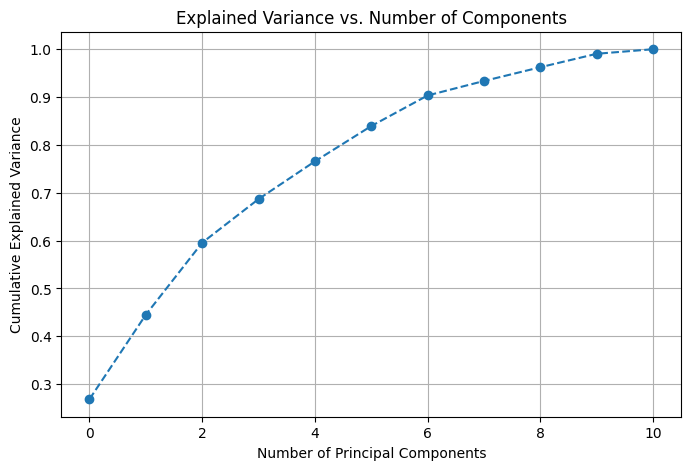

In [141]:
# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train[feature_names])

# Plot explained variance ratio
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

In [152]:
# Apply PCA with chosen number of components
n_components = 3  # Adjust based on explained variance plot
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train[feature_names])
X_test_pca = pca.transform(X_test[feature_names])

# Train the model
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)

# Evaluate the model
print(f"Evaluation for pca: {n_components} components")
print("Classification Report:\n", classification_report(y_test, y_pred))

Evaluation for pca: 3 components
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      2047
           1       0.69      0.68      0.68       431

    accuracy                           0.89      2478
   macro avg       0.81      0.81      0.81      2478
weighted avg       0.89      0.89      0.89      2478



In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation on different feature sets
for features in feature_sets:
    X_fs = X[features]
    
    # Train and evaluate using cross-validation
    scores = cross_val_score(clf, X_fs, y, cv=5, scoring='accuracy')
    print(f"Cross-validation scores for feature set {features}: {scores}")
    print(f"Average cross-validation accuracy: {scores.mean()}")

Cross-validation scores for feature set ['Human']: [0.91023701 0.88703984 0.89909183 0.8950555  0.89455096]
Average cross-validation accuracy: 0.8971950275627394
Cross-validation scores for feature set ['Human', 'Subject Focus', 'Accessory', 'Collage', 'Info']: [0.20322743 0.19768028 0.19677094 0.20534813 0.19525732]
Average cross-validation accuracy: 0.19965682061396745
Cross-validation scores for feature set ['Human', 'Info', 'Subject Focus']: [0.20322743 0.19768028 0.19677094 0.20534813 0.19525732]
Average cross-validation accuracy: 0.19965682061396745
Cross-validation scores for feature set ['Human', 'Accessory', 'Subject Focus', 'Group', 'Info']: [0.20322743 0.19768028 0.19677094 0.20534813 0.19525732]
Average cross-validation accuracy: 0.19965682061396745
Cross-validation scores for feature set ['Subject Focus', 'Eyes', 'Face', 'Near', 'Accessory', 'Group', 'Collage', 'Human', 'Info', 'Blur']: [0.20322743 0.19768028 0.19727548 0.20534813 0.19525732]
Average cross-validation accur

In [ ]:
best_features = feature_set_1

In [ ]:
X_train = X_train[best_features]
X_test = X_test[best_features]

# Train the model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2047
           1       0.71      0.66      0.69       431

    accuracy                           0.89      2478
   macro avg       0.82      0.80      0.81      2478
weighted avg       0.89      0.89      0.89      2478



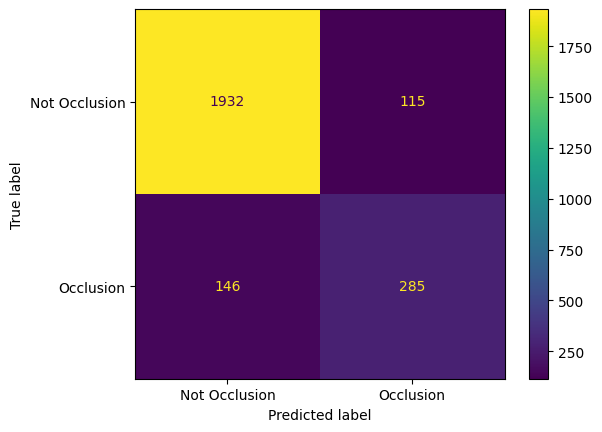

In [ ]:
labels = ["Not Occlusion", "Occlusion"]
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

In [ ]:
test_data = pd.read_csv('Data/test.csv')
test_data = test_data[best_features]

results = clf.predict_proba(test_data)

print(results)

[[0.96572183 0.03427817]
 [0.96572183 0.03427817]
 [0.96572183 0.03427817]
 [0.96572183 0.03427817]
 [0.96572183 0.03427817]
 [0.00428591 0.99571409]
 [0.96572183 0.03427817]
 [0.00428591 0.99571409]]


The numbers returned by predict_proba are the raw probabilities for each class, but they are indeed in a range of [0, 1] (not percentages). The values represent the model's estimated probability of each sample belonging to each class. Here's a more intuitive explanation:

1.00000000e+00 is equivalent to a probability of 100% for class 0, and 0.00000000e+00 means 0% for class 1.
9.99972102e-01 corresponds to approximately 99.9972% for class 1, and 2.78975483e-05 corresponds to about 0.0028% for class 0.